In [ ]:
from notebooks import *

In [ ]:
load = Load()
recs = recs if 'recs' in locals() else load.recs(
    # limit=30,  # XXX Faster dev
    datasets=[
        'peterson-field-guide',
        # 'recordings',
    ],
)
display(
    # df_summary(recs).T,
    # df_summary(recs),
    # recs[:5],
)

In [ ]:
# (recs
#     .assign(species=lambda df: df.species_longhand)
#     .assign(count=1)
#     # 0-fill all (species, dataset) combinations to create empty placeholders for missing bars
#     .pipe(lambda df: df.append(
#         pd.DataFrame([
#             dict(species=species, dataset=dataset, duration_s=0)
#             for species in df.species.unique()
#             for dataset in df.dataset.unique()
#         ])
#         .astype({'species': df.species.dtype})
#     ))
#     .groupby(['dataset', 'species'])[['count', 'duration_s']].sum().reset_index()
#     .pipe(pd.melt, id_vars=['dataset', 'species'], value_vars=['count', 'duration_s'])
#     .pipe(df_reverse_cat, 'species')
#     .pipe(ggplot, aes(x='species', y='value', fill='dataset', color='dataset'))
#     + coord_flip()
#     + geom_bar(stat='identity', position=position_dodge(), width=.8)
#     + facet_wrap('variable', nrow=1, scales='free')
#     + xlab('')
#     + ylab('')
#     + scale_fill_cmap_d(mpl.cm.tab10)
#     + scale_color_cmap_d(mpl.cm.tab10)
#     + theme(panel_spacing=2.5)
#     + theme_figsize(width=10, aspect_ratio=3/1)
#     + ggtitle(f'recs: Total (count, duration_s) per (species, dataset)')
# )

In [ ]:
# Load a saved projection model
projection = Projection.load('peterson-v0-26bae1c', features=Features(load=load))

[23:03:12.523] Projection.load
  path: /Users/danb/hack/bubo/data/models/projection/peterson-v0-26bae1c.pkl


In [ ]:
# Add .feat
recs = projection.transform(recs)

[                                                                                          ] | 0% Completed |  0.0s

[                                                                                          ] | 0% Completed |  0.1s

[##################                                                                        ] | 20% Completed |  0.2s

[##################                                                                        ] | 20% Completed |  0.3s

[####################################                                                      ] | 41% Completed |  0.4s

[######################################                                                    ] | 42% Completed |  0.5s

[#######################################################                                   ] | 61% Completed |  0.6s

[################################################################                          ] | 71% Completed |  0.7s

[############################################################################              ] | 84% Completed |  0.8s

[##########################################################################################] | 100% Completed |  1.0s

In [ ]:
# Example CV (http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)
from sklearn import datasets, linear_model, model_selection
diabetes = datasets.load_diabetes()
X, y = diabetes.data[:150], diabetes.target[:150]
lasso = linear_model.Lasso()
DF(model_selection.cross_validate(
    lasso, X, y,
    cv=5,
    return_train_score=True,
    verbose=10,
    n_jobs=16,
))

[CV]  ................................................................


[CV]  ................................................................


[CV]  ................................................................


[CV]  ................................................................


[CV]  ................................................................


[CV] ...................... , score=0.22414974810014598, total=   0.0s


[CV] ....................... , score=0.2982875885219344, total=   0.0s


[CV] ...................... , score=0.15479913227922903, total=   0.0s


[CV] ....................... , score=0.2551969087315188, total=   0.0s


[CV] ....................... , score=0.1710903644830516, total=   0.0s


[Parallel(n_jobs=16)]: Batch computation too fast (0.0150s.) Setting batch_size=26.
[Parallel(n_jobs=16)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done   5 out of   5 | elapsed:    0.0s finished


,fit_time,score_time,test_score,train_score
0,0.003,8.440e-04,0.298,0.328
1,0.003,9.200e-04,0.224,0.315
2,0.003,9.820e-04,0.155,0.340
3,0.003,8.640e-04,0.255,0.321
4,0.003,8.180e-04,0.171,0.274


In [ ]:
# CV one model
search = Search(projection=projection, n_neighbors=5)
X = recs.feat
y = recs.species
with log.context(verbose=False):
    DF(model_selection.cross_validate(
        search, X, y,
        cv=3,  # TODO Get more instances per class, so that instances_per_class >> cv
        return_train_score=True,
        verbose=10,
        n_jobs=16,
    ))

[CV]  ................................................................


[CV]  ................................................................


[CV]  ................................................................


[CV] ...................... , score=-16.460732984293195, total=   0.6s


[CV] ....................... , score=-19.39887640449438, total=   0.6s


[CV] ...................... , score=-17.433734939759034, total=   0.6s


[Parallel(n_jobs=16)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=16)]: Done   3 out of   3 | elapsed:    1.2s finished


In [ ]:
# Example GridSearchCV (http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
params = dict(
    kernel=('linear', 'rbf'),
    C=[1, 10],
)
iris = sk.datasets.load_iris()
select = sk.model_selection.GridSearchCV(
    sk.svm.SVC(),
    params,
    cv=3,
    return_train_score=True,
    verbose=10,
    n_jobs=16,
)
select.fit(iris.data, iris.target)
cv_results_dfs(select.cv_results_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[CV] C=1, kernel=linear ..............................................


[CV] C=1, kernel=linear ..............................................


[CV] C=1, kernel=linear ..............................................


[CV] C=1, kernel=rbf .................................................


[CV] C=1, kernel=rbf .................................................


[CV] C=1, kernel=rbf .................................................


[CV] C=10, kernel=linear .............................................


[CV] .................... C=1, kernel=linear, score=1.0, total=   0.0s


[CV] ..... C=1, kernel=linear, score=0.9607843137254902, total=   0.0s


[CV] ..... C=1, kernel=linear, score=0.9791666666666666, total=   0.0s


[CV] C=10, kernel=linear .............................................


[CV] ........ C=1, kernel=rbf, score=0.9607843137254902, total=   0.0s


[CV] C=10, kernel=linear .............................................


[CV] ........ C=1, kernel=rbf, score=0.9803921568627451, total=   0.0s


[CV] C=10, kernel=rbf ................................................


[CV] ........ C=1, kernel=rbf, score=0.9791666666666666, total=   0.0s


[CV] C=10, kernel=rbf ................................................


[CV] ................... C=10, kernel=linear, score=1.0, total=   0.0s


[CV] C=10, kernel=rbf ................................................


[CV] .... C=10, kernel=linear, score=0.9215686274509803, total=   0.0s


[CV] ................... C=10, kernel=linear, score=1.0, total=   0.0s


[CV] ....... C=10, kernel=rbf, score=0.9803921568627451, total=   0.0s


[CV] ....... C=10, kernel=rbf, score=0.9607843137254902, total=   0.0s


[CV] ...................... C=10, kernel=rbf, score=1.0, total=   0.0s


[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Batch computation too fast (0.0237s.) Setting batch_size=16.
[Parallel(n_jobs=16)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=16)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done   7 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done   9 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  12 out of  12 | elapsed:    0.0s finished


(
    param_C param_kernel  mean_train_score  std_train_score  mean_test_score  std_test_score  rank_test_score  mean_fit_time  std_fit_time  mean_score_time  std_score_time
  0       1       linear             0.990            0.008            0.980           0.016                1          0.002     7.828e-05        8.454e-04       2.182e-05
  1       1          rbf             0.983            0.013            0.973           0.009                3          0.003     1.272e-04        8.776e-04       2.295e-05
  2      10       linear             0.980            0.016            0.973           0.037                3          0.002     1.098e-04        8.300e-04       5.499e-05
  3      10          rbf             0.980            0.016            0.980           0.016                1          0.002     8.402e-05        8.177e-04       4.645e-05,
     param_C param_kernel fold  split  score
  0        1       linear    0   test  1.000
  1        1       linear    0  train  0.980
  

In [ ]:
# GridSearchCV many models / model params
params = dict(
    n_neighbors=[1, 5, 15, 25, 50, 100, 150],
    # TODO agg_funs
)
search = Search(projection=projection)
X, y = search.Xy(recs)
select = sk.model_selection.GridSearchCV(
    Search(projection=projection),
    params,
    # cv=3,  # XXX No more kfold!
    cv=model_selection.ShuffleSplit(
        n_splits=20,  # TODO TODO Make this bigger!
        test_size=.2,
        random_state=0,
    ),
    return_train_score=True,
    # verbose=100,
    # verbose=10,
    verbose=1,
    n_jobs=20,
)
with log.context(verbose=False):
    select.fit(X, y)

Fitting 20 folds for each of 7 candidates, totalling 140 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    1.1s


[Parallel(n_jobs=20)]: Done 140 out of 140 | elapsed:   14.1s finished


In [ ]:
cv_results_summary_df(select.cv_results_)
cv_results_summary_df(select.cv_results_).filter(regex='param|time')

,param_n_neighbors,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,1,-1.00,0.000,-23.80,1.370,7,0.047,0.007,0.350,0.046
1,5,-2.59,0.045,-15.20,1.150,6,0.080,0.018,0.403,0.017
2,15,-3.86,0.109,-10.70,1.100,4,0.089,0.010,0.416,0.009
3,25,-4.61,0.131,-9.78,0.925,2,0.082,0.013,0.442,0.010
4,50,-5.81,0.111,-9.27,0.670,1,0.084,0.009,0.422,0.011
5,100,-7.40,0.141,-10.00,0.575,3,0.085,0.014,0.439,0.012
6,150,-8.84,0.141,-11.40,0.718,5,0.079,0.011,0.432,0.010


,param_n_neighbors,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,1,0.047,0.007,0.350,0.046
1,5,0.080,0.018,0.403,0.017
2,15,0.089,0.010,0.416,0.009
3,25,0.082,0.013,0.442,0.010
4,50,0.084,0.009,0.422,0.011
5,100,0.085,0.014,0.439,0.012
6,150,0.079,0.011,0.432,0.010


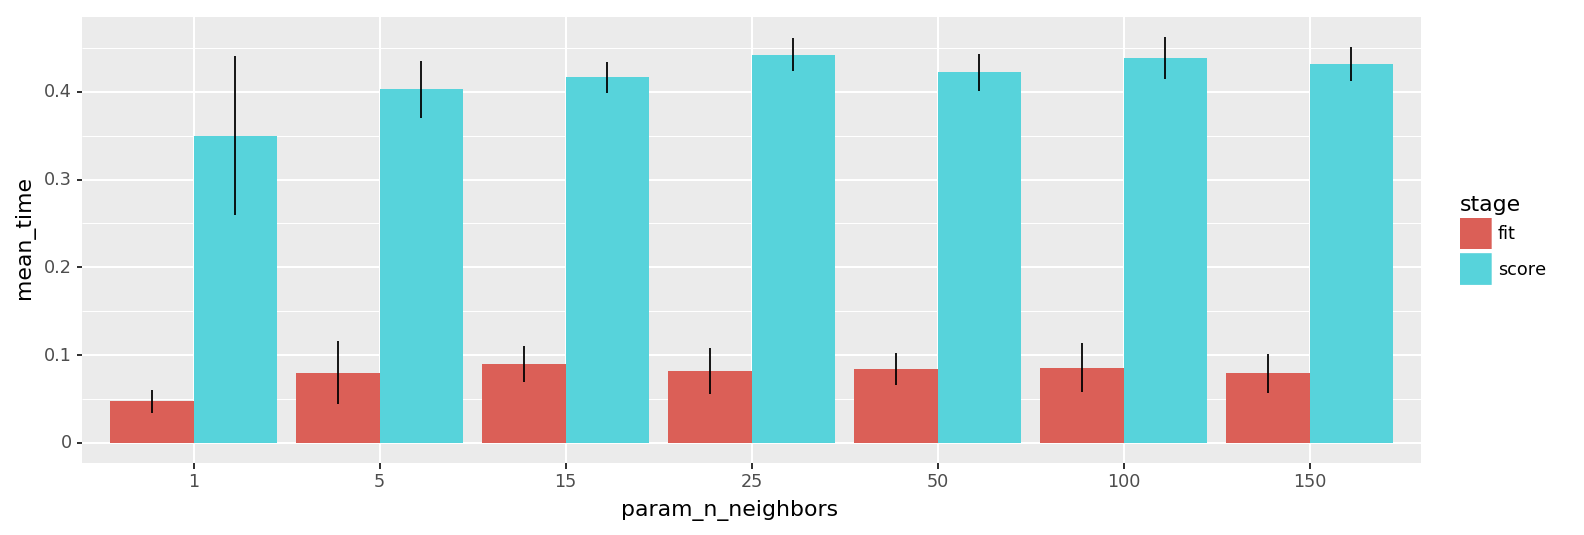

In [ ]:
with warnings.catch_warnings():
    # TODO How to avoid the 'color' legend warning since geom_col has no color mapping?
    warnings.simplefilter(action='ignore', category=UserWarning)
    repr(cv_results_summary_df(select.cv_results_)
        .filter(regex='^(param_.*|.*_time$)')
        .pipe(df_flatmap, lambda row: [
            row.set_value('stage', 'fit').rename({'mean_fit_time': 'mean_time', 'std_fit_time': 'std_time'}),
            row.set_value('stage', 'score').rename({'mean_score_time': 'mean_time', 'std_score_time': 'std_time'}),
        ])
        .filter(regex='^(param.*|stage|mean_time|std_time)$')
        .pipe(lambda df: df.astype({c: 'category' for c in df if c.startswith('param_')}))
        .pipe(ggplot, aes(x='param_n_neighbors'))
        + geom_col(aes(y='mean_time', fill='stage'), position=position_dodge())
        + geom_linerange(
            aes(group='stage', y='mean_time', ymin='mean_time - 1.96 * std_time', ymax='mean_time + 1.96 * std_time'),
            position=position_dodge(width=.9),
        )
        + scale_color_cmap_d(mpl.cm.Set1)
    )

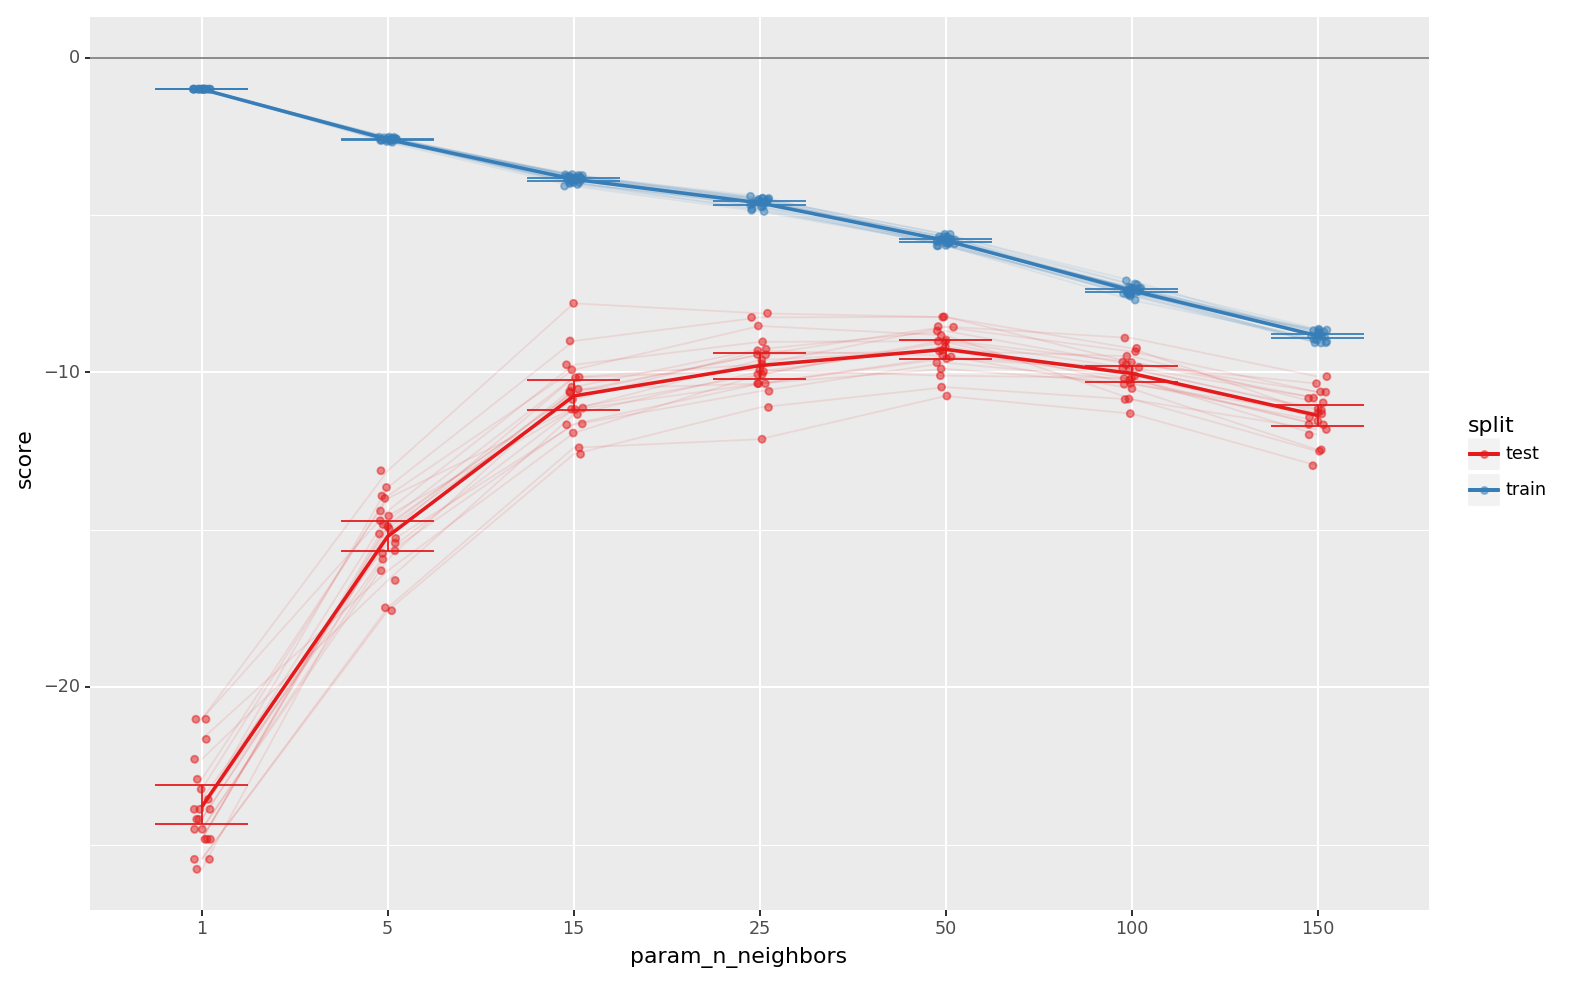

<ggplot: (331310186)>

In [ ]:
(cv_results_splits_df(select.cv_results_)
    .astype({'param_n_neighbors': 'category'})
    .pipe(ggplot, aes(x='param_n_neighbors', y='score', color='split'))
    + geom_hline(yintercept=0, color='grey')
    + geom_jitter(alpha=.5, width=.05)
    + geom_line(aes(group='split + fold'), alpha=.1)
    + stat_summary(aes(group='split'), fun_data='mean_cl_boot', random_state=0, geom='errorbar')
    + stat_summary(aes(group='split'), fun_data='mean_cl_boot', random_state=0, geom='line', size=1)
    + scale_color_cmap_d(mpl.cm.Set1)
    + theme_figsize('inline')
)

In [ ]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
recs_eval = (recs
    [lambda df: df.dataset == 'peterson-field-guide']
    # [:10]  # Faster dev
    .reset_index(drop=True)
)
train_n, test_n = (len(recs_eval)+1)//2, len(recs_eval)//2
recs_train, recs_test = (recs_eval
    .pipe(sklearn.utils.shuffle, random_state=0)
    .sample(train_n + test_n, random_state=0)
    .pipe(lambda df: (
        df[:train_n],
        df[train_n : train_n + test_n],
    ))
)
log('params', **{
    'recs_eval': len(recs_eval),
    'recs_train': len(recs_train),
    'recs_test': len(recs_test),
})

In [ ]:
search = Search(
    projection=projection,
    # n_neighbors=3,
    n_neighbors=5,
    # n_neighbors=10,
)
search.fit_recs(recs_train)

# Compare models

In [ ]:
search.score(recs_test)

In [ ]:
search.coverage_error(recs_test)